In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ift6758.training import AdvancedModel
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

In [3]:
train_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets.pkl')
X_all = train_val.drop(['is_goal'], axis=1)
y_all = train_val['is_goal']

train2_val = pd.read_pickle('../../notebooks/Milestone2/TrainValSets2.pkl')
X2_all = train2_val.drop(['is_goal'], axis=1)
y2_all = train2_val['is_goal']

# Split into train val
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_all, y2_all, test_size=0.3, random_state=42)


In [4]:
modelsDict = {
    'xgboost_distance-angle': AdvancedModel(pickle.load(open('../../train/xgboost_distance-angle/model.pkl', 'rb'))).get_pred_proba(X2_val[['distance_goal', 'angle_shot']])
    ,'xgboost_allFeatures': AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).get_pred_proba(X2_val[['period' ,'game_seconds' ,'x', 'y', 'empty_net', 'prev_x', 'prev_y', 'time_since_prev', 'distance_from_prev', 'distance_goal', 'prev_distance_goal', 'angle_shot', 'prev_angle_shot', 'bounce', 'angle_change', 'speed', 'shot_type_Deflected', 'shot_type_Slap_Shot' ,'shot_type_Snap_Shot', 'shot_type_Tip-In', 'shot_type_Wrap-around', 'shot_type_Wrist_Shot', 'prev_type_FACEOFF', 'prev_type_GIVEAWAY', 'prev_type_GOAL', 'prev_type_HIT', 'prev_type_MISSED_SHOT', 'prev_type_PENALTY' ,'prev_type_SHOT' ,'prev_type_TAKEAWAY']])
, 'xgboost_RFECVtop21Features': AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top21/model.pkl', 'rb'))).get_pred_proba(X2_val[['empty_net',
 'distance_goal', 'shot_type_Wrap-around','y','shot_type_Slap_Shot','shot_type_Deflected','period','shot_type_Snap_Shot','prev_type_HIT','time_since_prev','shot_type_Tip-In','angle_shot','prev_type_GIVEAWAY','shot_type_Wrist_Shot','bounce','angle_change','game_seconds','speed','prev_distance_goal','prev_type_SHOT','prev_angle_shot']])
}

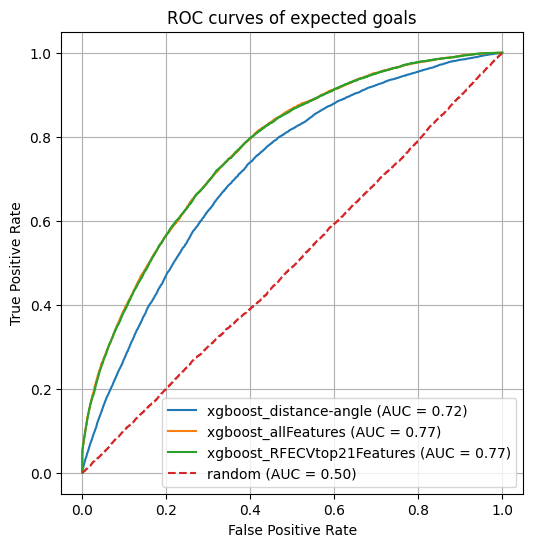

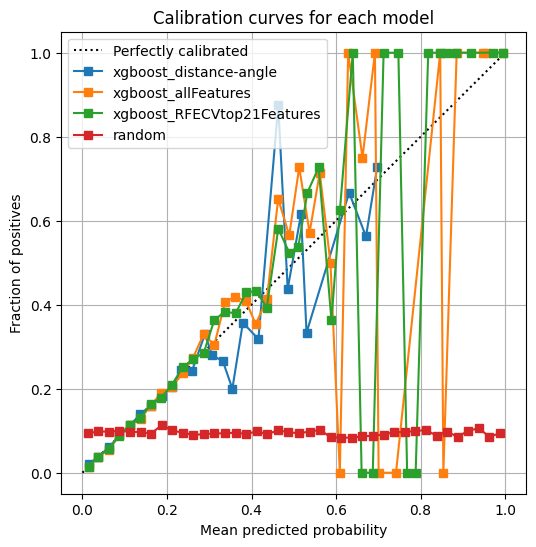

/Users/JJKaufman/DESS/IFT6758/IFT6758-A5-NHL/ift6758/training/plot.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate = df.groupby(centiles).is_goal.mean()


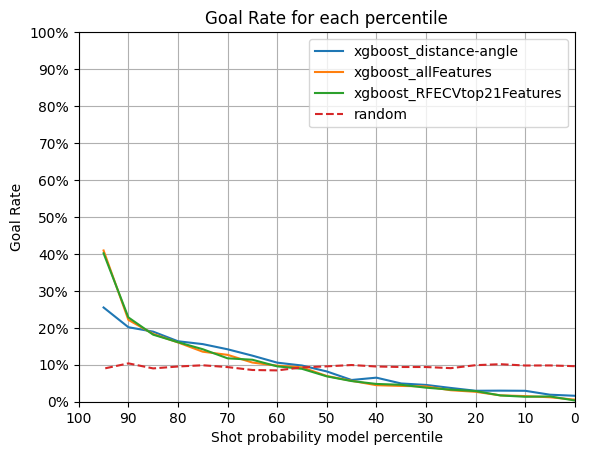

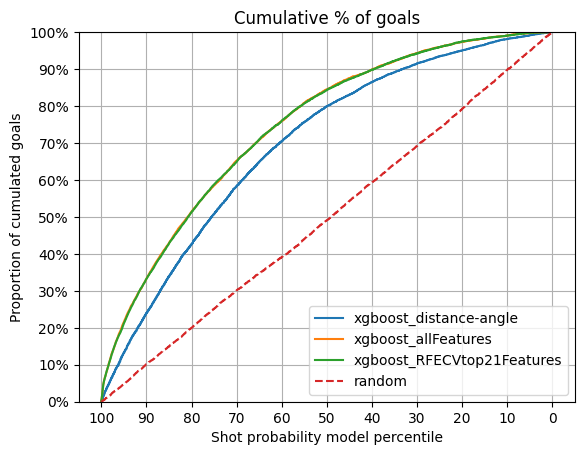

In [5]:
from ift6758.training.plot import plot_all
plot_all(modelsDict, y2_val)

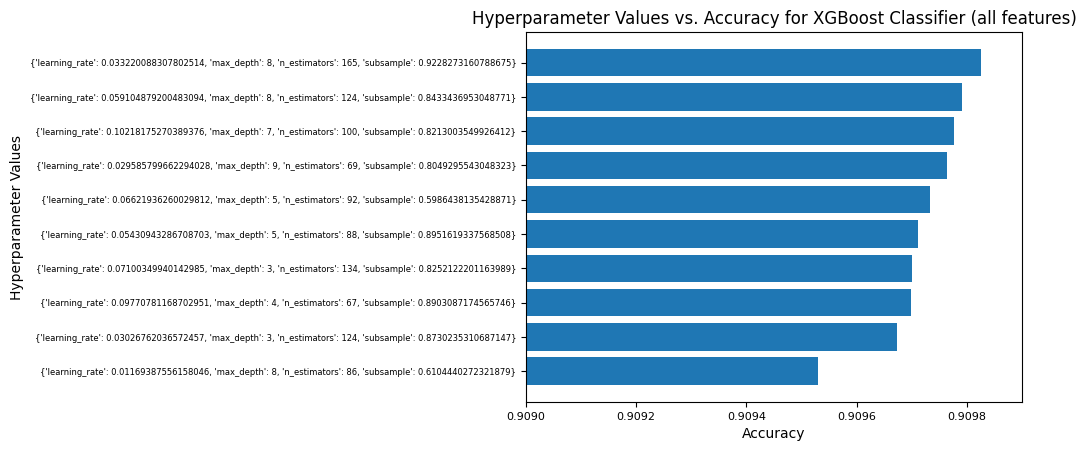

In [6]:
AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).hp_plot()

In [7]:
import matplotlib.pyplot as plt
y1 = AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).clf.feature_importances_
x1 = AdvancedModel(pickle.load(open('../../train/xgboost_allFeatures/model.pkl', 'rb'))).clf.get_booster().feature_names

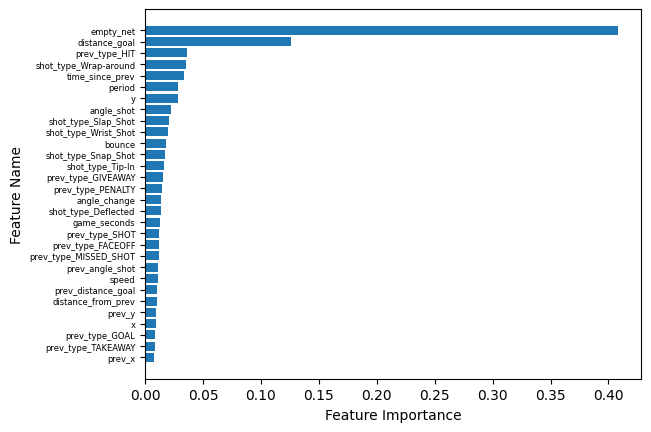

In [8]:
res = [list(i) for i in zip(*sorted(zip(y1, x1),
                                  key = lambda dual: dual[0]))]
x2 = res[1]
y2 = res[0]
plt.barh(x2, y2)
plt.yticks(range(len(x2)), x2, fontsize = 6)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

In [9]:
import numpy as np
np.mean(y2)

0.03333334

In [10]:
np.median(y2)

0.014198288

In [11]:
np.sum(y2>np.mean(y2))

5

In [12]:
import xgboost as xgb
modele = AdvancedModel(xgb.XGBClassifier())

In [13]:
newX_train = modele.featureSelect(X2_train, y2_train)

In [14]:
newX_train

,empty_net
66240,False
192026,False
96963,False
63577,False
156159,False
...,...
119879,False
259178,False
131932,False
146867,False


In [15]:
scores = modele.featScores['mean_test_score']

In [16]:
names = modele.rfecv.feature_names_in_

In [17]:
ranking = modele.rfecv.ranking_

In [18]:
feats = [list(i) for i in zip(*sorted(zip(names, ranking),
                                  key = lambda dual: dual[1]))]

In [19]:
feats[0][0:21]

['empty_net',
 'distance_goal',
 'shot_type_Wrap-around',
 'y',
 'shot_type_Slap_Shot',
 'shot_type_Snap_Shot',
 'period',
 'shot_type_Deflected',
 'prev_type_HIT',
 'time_since_prev',
 'angle_shot',
 'shot_type_Tip-In',
 'prev_type_GIVEAWAY',
 'shot_type_Wrist_Shot',
 'game_seconds',
 'bounce',
 'speed',
 'prev_angle_shot',
 'prev_distance_goal',
 'angle_change',
 'distance_from_prev']

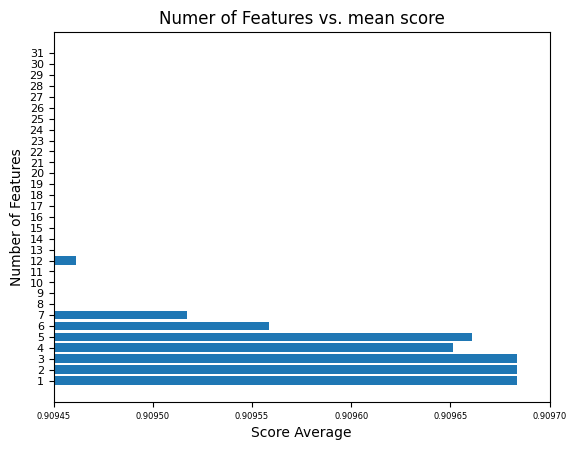

In [38]:
plt.barh(range(1, len(scores)+1), scores)        
plt.xlim(0.90945, .9097)
plt.yticks(range(1, len(scores)+1), range(1, len(scores)+1), fontsize = 8)
plt.xticks(fontsize = 6)
plt.xlabel('Score Average')
plt.ylabel('Number of Features')
plt.title('Numer of Features vs. mean score')
plt.show()

In [21]:
modele.selectedFeatures

array([5])

In [22]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedStratifiedKFold
# Create the LASSO model
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

lasso_model = LassoCV(cv = kfold)

# Fit the model
lasso_model.fit(X2_train, y2_train)

# Get selected features
selected_features = X2_train.columns[lasso_model.coef_ != 0]

In [23]:
selected_features

Index(['game_id', 'game_seconds'], dtype='object')

In [24]:
lasso_model.coef_

array([ 2.62111798e-09,  0.00000000e+00,  1.29150890e-05, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

<BarContainer object of 2 artists>

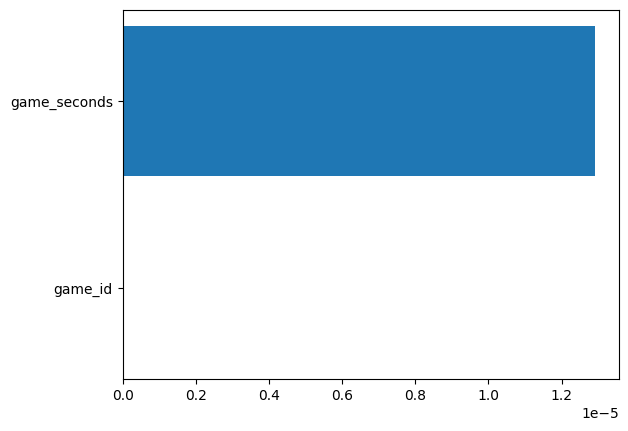

In [25]:
plt.barh(selected_features, lasso_model.coef_[lasso_model.coef_ != 0])

In [26]:
import shap


In [27]:
mo = AdvancedModel(xgb.XGBClassifier())

In [28]:
mo.train(X2_train, y2_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
explainer = shap.Explainer(mo.clf)
shap_values = explainer(X2_train)

[15:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


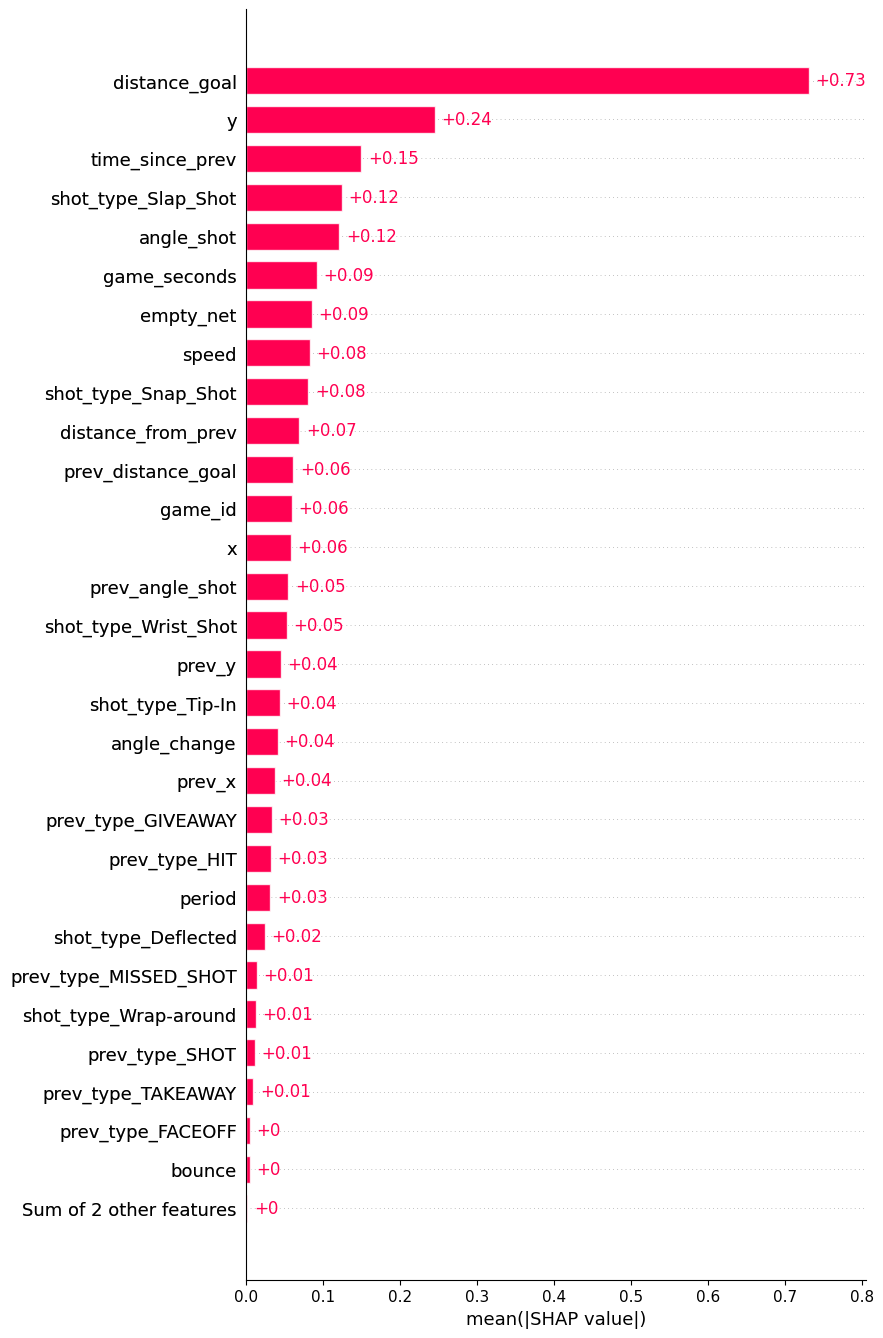

In [30]:
shap.plots.bar(shap_values, max_display = 30)

In [39]:
lasso = AdvancedModel(pickle.load(open('../../train/xgboost_LASSO/model.pkl', 'rb')))

In [44]:
lassoSEL = ['game_seconds', 'prev_x', 'prev_y', 'time_since_prev',
       'distance_from_prev', 'distance_goal', 'prev_distance_goal',
       'angle_shot', 'speed']

In [45]:
y2_pred, accuracyLasso = lasso.evaluate(X2_val[lassoSEL], y2_val)

In [46]:
lasso2Sel = ['time_since_prev',
       'distance_from_prev', 'distance_goal', 'prev_distance_goal',
       'angle_shot', 'speed']

In [47]:
lasso2 = AdvancedModel(pickle.load(open('../../train/xgboost_LASSO2/model.pkl', 'rb')))

In [48]:
y2_pred2, accuracyLasso2 = lasso2.evaluate(X2_val[lasso2Sel], y2_val)

In [49]:
shap01Sel = ['distance_goal', 'y' ,'time_since_prev', 'angle_shot', 'shot_type_Slap_Shot','game_seconds' ,'empty_net', 'prev_distance_goal' ,'speed', 'shot_type_Snap_Shot' ,'distance_from_prev', 'prev_angle_shot']


In [50]:
shap1 = AdvancedModel(pickle.load(open('../../train/xgboost_SHAP01/model.pkl', 'rb')))

In [51]:
y2_pred3, accuracySHAP1 = shap1.evaluate(X2_val[shap01Sel], y2_val)

In [52]:
shap02Sel = ['distance_goal', 'y' ,'time_since_prev', 'angle_shot', 'shot_type_Slap_Shot','game_seconds' ,'empty_net', 'prev_distance_goal' ,'speed', 'shot_type_Snap_Shot' ]


In [53]:
shap2 = AdvancedModel(pickle.load(open('../../train/xgboost_SHAP02/model.pkl', 'rb')))


In [54]:
y2_pred4, accuracySHAP2 = shap2.evaluate(X2_val[shap02Sel], y2_val)

In [55]:
shap03Sel = ['distance_goal', 'y' ,'time_since_prev', 'angle_shot', 'shot_type_Slap_Shot','game_seconds' ,'empty_net']


In [56]:
shap3 = AdvancedModel(pickle.load(open('../../train/xgboost_SHAP03/model.pkl', 'rb')))


In [57]:
y2_pred5, accuracySHAP3 = shap3.evaluate(X2_val[shap03Sel], y2_val)

In [58]:
top21Sel = ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'prev_type_HIT', 'time_since_prev', 'y', 'period', 'angle_shot', 'shot_type_Slap_Shot', 'shot_type_Wrist_Shot', 'shot_type_Snap_Shot', 'bounce', 'shot_type_Tip-In', 'prev_type_GIVEAWAY' ,'shot_type_Deflected', 'prev_type_FACEOFF', 'prev_type_SHOT', 'angle_change', 'game_seconds' ,'prev_type_MISSED_SHOT', 'speed']


In [59]:
top21 = AdvancedModel(pickle.load(open('../../train/xgboost_top21/model.pkl', 'rb')))


In [60]:
y2_pred6, accuracytop21 = top21.evaluate(X2_val[top21Sel], y2_val)

In [61]:
top05Sel = ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'prev_type_HIT', 'time_since_prev']


In [62]:
top5 = AdvancedModel(pickle.load(open('../../train/xgboost_top5/model.pkl', 'rb')))


In [63]:
y2_pred7, accuracytop5 = top5.evaluate(X2_val[top05Sel], y2_val)

In [64]:
top03Sel = ['empty_net', 'distance_goal', 'shot_type_Wrap-around']


In [65]:
top3 = AdvancedModel(pickle.load(open('../../train/xgboost_top3/model.pkl', 'rb')))


In [66]:
y2_pred8, accuracytop3 = top3.evaluate(X2_val[top03Sel], y2_val)

In [67]:
#trying one top 5 RFECV selected

In [68]:
feats[0][0:5]

['empty_net',
 'distance_goal',
 'shot_type_Wrap-around',
 'y',
 'shot_type_Slap_Shot']

In [69]:
RFECVtop5 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top5/model.pkl', 'rb')))

In [70]:
top05RFECV = feats[0][0:5]

In [71]:
y2_pred9, accuracyRFECVtop5 = RFECVtop5.evaluate(X2_val[top05RFECV], y2_val)

In [72]:
top21RFECV= feats[0][0:21]

In [73]:
RFECVtop21 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top21/model.pkl', 'rb')))

In [75]:
y2_pred10, accuracyRFECVtop21 = RFECVtop21.evaluate(X2_val[top21RFECV], y2_val)

ValueError: feature_names mismatch: ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Deflected', 'period', 'shot_type_Snap_Shot', 'prev_type_HIT', 'time_since_prev', 'shot_type_Tip-In', 'angle_shot', 'prev_type_GIVEAWAY', 'shot_type_Wrist_Shot', 'bounce', 'angle_change', 'game_seconds', 'speed', 'prev_distance_goal', 'prev_type_SHOT', 'prev_angle_shot'] ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Snap_Shot', 'period', 'shot_type_Deflected', 'prev_type_HIT', 'time_since_prev', 'angle_shot', 'shot_type_Tip-In', 'prev_type_GIVEAWAY', 'shot_type_Wrist_Shot', 'game_seconds', 'bounce', 'speed', 'prev_angle_shot', 'prev_distance_goal', 'angle_change', 'distance_from_prev']
expected prev_type_SHOT in input data
training data did not have the following fields: distance_from_prev

In [76]:
top18RFECV = feats[0][0:18]

In [77]:
RFECVtop18 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top18/model.pkl', 'rb')))

In [78]:
y2_pred11, accuracyRFECVtop18 = RFECVtop18.evaluate(X2_val[top18RFECV], y2_val)

ValueError: feature_names mismatch: ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Deflected', 'period', 'shot_type_Snap_Shot', 'prev_type_HIT', 'time_since_prev', 'shot_type_Tip-In', 'angle_shot', 'prev_type_GIVEAWAY', 'shot_type_Wrist_Shot', 'bounce', 'angle_change', 'game_seconds', 'speed'] ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Snap_Shot', 'period', 'shot_type_Deflected', 'prev_type_HIT', 'time_since_prev', 'angle_shot', 'shot_type_Tip-In', 'prev_type_GIVEAWAY', 'shot_type_Wrist_Shot', 'game_seconds', 'bounce', 'speed', 'prev_angle_shot']
expected angle_change in input data
training data did not have the following fields: prev_angle_shot

In [79]:
top19RFECV = feats[0][0:19]

In [80]:
RFECVtop19 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top19/model.pkl', 'rb')))

In [81]:
y2_pred12, accuracyRFECVtop19 = RFECVtop19.evaluate(X2_val[top19RFECV], y2_val)

ValueError: feature_names mismatch: ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Deflected', 'period', 'shot_type_Snap_Shot', 'prev_type_HIT', 'time_since_prev', 'shot_type_Tip-In', 'angle_shot', 'prev_type_GIVEAWAY', 'shot_type_Wrist_Shot', 'bounce', 'angle_change', 'game_seconds', 'speed', 'prev_distance_goal'] ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Snap_Shot', 'period', 'shot_type_Deflected', 'prev_type_HIT', 'time_since_prev', 'angle_shot', 'shot_type_Tip-In', 'prev_type_GIVEAWAY', 'shot_type_Wrist_Shot', 'game_seconds', 'bounce', 'speed', 'prev_angle_shot', 'prev_distance_goal']
expected angle_change in input data
training data did not have the following fields: prev_angle_shot

In [82]:
top6RFECV = feats[0][0:6]

In [83]:
RFECVtop6 = AdvancedModel(pickle.load(open('../../train/xgboost_RFECV_top6/model.pkl', 'rb')))

In [84]:
y2_pred13, accuracyRFECVtop6 = RFECVtop6.evaluate(X2_val[top6RFECV], y2_val)

ValueError: feature_names mismatch: ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Deflected'] ['empty_net', 'distance_goal', 'shot_type_Wrap-around', 'y', 'shot_type_Slap_Shot', 'shot_type_Snap_Shot']
expected shot_type_Deflected in input data
training data did not have the following fields: shot_type_Snap_Shot

In [85]:
dict = {'RFECV Top 6':accuracyRFECVtop6,'RFECV Top 19':accuracyRFECVtop19,'RFECV Top 18': accuracyRFECVtop18,'RFECV Top 21':accuracyRFECVtop21,'RFECV Top 5':accuracyRFECVtop5,'LASSO': accuracyLasso, 'LASSO 2 Removed':accuracyLasso2, 'SHAP > .05':accuracySHAP1,'SHAP > .07':accuracySHAP2,'SHAP>.08':accuracySHAP3, 'Top 21': accuracytop21, 'Top 5': accuracytop5, 'Top 3': accuracytop3}

NameError: name 'accuracyRFECVtop6' is not defined

In [86]:
dict = {'RFECV Top 5':accuracyRFECVtop5,'LASSO': accuracyLasso, 'LASSO 2 Removed':accuracyLasso2, 'SHAP > .05':accuracySHAP1,'SHAP > .07':accuracySHAP2,'SHAP>.08':accuracySHAP3, 'Top 21': accuracytop21, 'Top 5': accuracytop5, 'Top 3': accuracytop3}


Text(0.5, 1.0, 'Feature Selection Method vs. Accuracy on Validation Set')

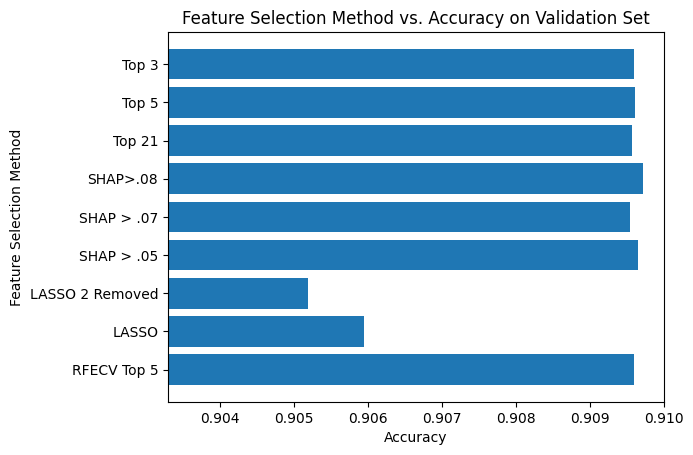

In [89]:
plt.barh(*zip(*dict.items()))
plt.xlim(.9033, .91)
plt.xlabel('Accuracy')
plt.ylabel('Feature Selection Method')
plt.title('Feature Selection Method vs. Accuracy on Validation Set')

Text(0.5, 1.0, 'Feature Selection Method vs. Accuracy on Validation Set')

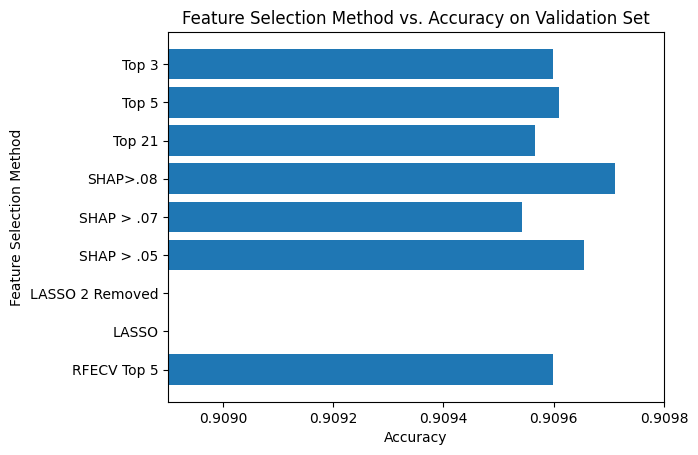

In [90]:
plt.barh(*zip(*dict.items()))
plt.xlim(.9089, .9098)
plt.xlabel('Accuracy')
plt.ylabel('Feature Selection Method')
plt.title('Feature Selection Method vs. Accuracy on Validation Set')